In [1]:
from collections import defaultdict
from itertools import permutations
from queue import Queue

import matplotlib.pyplot as plt
import numpy as np
import os

import pickle
import time

from random import choice, sample, shuffle

In [2]:
switch_literal = lambda x: x[1:] if x.startswith('-') else '-'+x
deepcopy = lambda x: pickle.loads(pickle.dumps(x))

def parse_input(input_file):
    
    """
    literal_clauseNum: {Literal: Set of clause numbers that are still in consideration for this variable}                        
    
    clauseNum_clause: {Clause number: Set of literals that could still satisfy this clause}
    
    literal_boolen: {Literal: boolean on whether literal set of True/False/None, None meaning could be either, doesn't matter}
    
    input_file:
    c DIMACS CNF: conjunction/AND of one or more clauses, where a clause is a disjunction/OR of literals
    c Comments start with a c, First lines begins with p and describes the probelm and all clause lines end with a 0
    c Can't have same variable in both forms in same clause. So A ~A is not allowed. Can have them in separate clauses.
                        
    """

    all_clauses = []  # List of all clauses that appear in input. Used for SAT checking the mapping given by DPLL

    literal_clauseNum = defaultdict(set)

    def filler():
        return None

    literal_boolen = defaultdict(filler)

    clauseNum_clause = {}

    clause_counter = 0

    with open(input_file, 'r') as fin:
        for line in fin:
            line = line.strip()
            # Do checks on comments
            if line.startswith('c') or line.startswith('p') or line.startswith('0') or line.startswith('%'):
                continue
            if len(line) > 0:
                clause = []
                clause_counter += 1
                for literal in line.split():
                    if literal == '0':
                        # End of line, ignore in DIMACS CNF format
                        continue
                    clause.append(literal)
                    literal_clauseNum[literal].add(clause_counter)
                clauseNum_clause[clause_counter] = set(clause)
                all_clauses.append(clause)

    return literal_clauseNum, clauseNum_clause, literal_boolen, all_clauses

def unit_prop(literal_clauseNum, clauseNum_clause, literal_boolen):
    keep_updating = True
    while keep_updating:
        keep_updating = False # Assuming we've found all unit clauses
        for clauseNum in list(clauseNum_clause.keys()):
            if clauseNum not in clauseNum_clause:
                continue
            clause = clauseNum_clause[clauseNum]
            # Clause contains the remaining literals that could potentially satisfy this clause. 
            if len(clause) == 0:
                # Empty clause, so need to return True for empty clause detected
                return True, None, None, None
            if len(clause) > 1:
                # Can't do unit prop 
                continue

            literal = clause.pop()  # Needs to be set to True
            clause.add(literal)  # Removed later
            literal_boolen[literal] = True
            keep_updating = True  # Since we found one unit clause, maybe more

    #         print(literal)
    #         print(literal_clauseNum)
    #         print(clauseNum_clause)

            # For all clauses that have this literal, they have been satisfied now
            # 1) Gather all pairs of (literals, clauseNum) that appear in these clauses so we can remove them from literal_clauseNum
            # 2) Delete these clauses from clauseNum_clause
            pairs_to_delete = []
            for clauseNums_with_literal in literal_clauseNum[literal]:
                for literals_in_clauseNums in clauseNum_clause[clauseNums_with_literal]:
                    pairs_to_delete.append((literals_in_clauseNums, clauseNums_with_literal))

    #         print(pairs_to_delete)

            for literals_in_clauseNums, clauseNums_with_literal in pairs_to_delete:
                literal_clauseNum[literals_in_clauseNums].discard(clauseNums_with_literal)
                if clauseNums_with_literal in clauseNum_clause:
                    del clauseNum_clause[clauseNums_with_literal]

            # For all the clauses with opposite literal, remove the literal from the clause
            if switch_literal(literal) not in literal_clauseNum: # if the opposite variable doesn't exist, skip
                continue

            opposite_literal = switch_literal(literal)
            literal_boolen[opposite_literal] = False

            for clauseNums_with_literal in literal_clauseNum[opposite_literal]:
                clauseNum_clause[clauseNums_with_literal].discard(opposite_literal)

            literal_clauseNum[opposite_literal] = set()  # It is not watching any clauses anymore

    #         print("OPPO")
    #         print(literal_clauseNum)
    #         print(clauseNum_clause)
        
    return False, literal_clauseNum, clauseNum_clause, literal_boolen


def pure_literal(literal_clauseNum, clauseNum_clause, literal_boolen):
    for literal in list(literal_clauseNum.keys()):
        if literal in literal_boolen:
            continue
        
        opposite_literal = switch_literal(literal)
        if opposite_literal not in literal_boolen: # The opposite variable has not been assigned yet
            # If it doesn't exist or it does but it doesn't have to satisfy any clauses
            if opposite_literal not in literal_clauseNum or len(literal_clauseNum[opposite_literal]) == 0:
                # LITERAL IS A PURE LITERAL
                literal_boolen[literal] = True
                
                # All the clauses that literal exists in has been made true, so remove the clauses and make literal watch no clause
                pairs_to_delete = []
                for clauseNums_with_literal in literal_clauseNum[literal]:
                    for literals_in_clauseNums in clauseNum_clause[clauseNums_with_literal]:
                        pairs_to_delete.append((literals_in_clauseNums, clauseNums_with_literal))

        #         print(pairs_to_delete)

                for literals_in_clauseNums, clauseNums_with_literal in pairs_to_delete:
                    literal_clauseNum[literals_in_clauseNums].discard(clauseNums_with_literal)
                    if clauseNums_with_literal in clauseNum_clause:
                        del clauseNum_clause[clauseNums_with_literal]
                        
    return literal_clauseNum, clauseNum_clause, literal_boolen


def maxo(literal_clauseNum, return_counts=False):
    literal_count = defaultdict(int)
    for literal, clauseNums in literal_clauseNum.items():
        literal_count[literal] = len(clauseNums)
    if return_counts:
        return literal_count
    
    max_lit = None
    max_count = 0
    for literal, count in literal_count.items():
        if count > max_count:
            max_count = count
            max_lit = literal
    return max_lit, max_count


def moms(literal_clauseNum, clauseNum_clause, return_counts=False):
    # Select the clausesNumbers for clauses of the smaller size
    least_size = min(map(len, clauseNum_clause.values()))
    literal_count = defaultdict(int)
    
    for literal, clauseNums in literal_clauseNum.items():
        for clauseNum in clauseNums:
            if len(clauseNum_clause[clauseNum]) == least_size:
                # Each time a literal appears in a least-size clause we 
                # increment counter by 1
                literal_count[literal] += 1
    
    if return_counts:
        return literal_count
    
    max_lit = None
    max_count = 0
    for literal, count in literal_count.items():
        if count > max_count:
            max_count = count
            max_lit = literal
    return max_lit, max_count


def mams(literal_clauseNum, clauseNum_clause):
    maxo_ans = maxo(literal_clauseNum, return_counts=True)
    moms_ans = moms(literal_clauseNum, clauseNum_clause, return_counts=True)
    
    # MAXO would return the dict with most keys
    for literal in maxo_ans:
        maxo_ans[literal] += moms_ans[literal]
        # Since using defaultdict we add 0 if literal not in moms_ans
    
    max_lit = None
    max_count = 0
    for literal, count in maxo_ans.items():
        if count > max_count:
            max_count = count
            max_lit = literal
    
    return max_lit, max_count


def jw(literal_clauseNum, clauseNum_clause):
    literal_score = defaultdict(int)
    
    for literal, clauseNums in literal_clauseNum.items():
        for clauseNum in clauseNums:
            clause = clauseNum_clause[clauseNum]
            literal_score[literal] += 2 ** -len(clause)
    
    max_lit = None
    max_score = 0
    for literal, score in literal_score.items():
        if score > max_score:
            max_score = score
            max_lit = literal
            
    return max_lit, max_score

def set_var(literal, boolean, literal_clauseNum, clauseNum_clause, literal_boolen):
    literal_boolen[literal] = boolean

    if boolean == False:
        literal = switch_literal(literal)
        literal_boolen[literal] = True
    
    # Unit-prop logic below
    pairs_to_delete = []
    for clauseNums_with_literal in literal_clauseNum[literal]:
        for literals_in_clauseNums in clauseNum_clause[clauseNums_with_literal]:
            pairs_to_delete.append((literals_in_clauseNums, clauseNums_with_literal))

    #         print(pairs_to_delete)

    for literals_in_clauseNums, clauseNums_with_literal in pairs_to_delete:
        literal_clauseNum[literals_in_clauseNums].discard(clauseNums_with_literal)
        if clauseNums_with_literal in clauseNum_clause:
            del clauseNum_clause[clauseNums_with_literal]

    # For all the clauses with opposite literal, remove the literal from the clause
    if switch_literal(literal) not in literal_clauseNum: # if the opposite variable doesn't exist, skip
        return literal_clauseNum, clauseNum_clause, literal_boolen

    opposite_literal = switch_literal(literal)
    literal_boolen[opposite_literal] = False

    for clauseNums_with_literal in literal_clauseNum[opposite_literal]:
        clauseNum_clause[clauseNums_with_literal].discard(opposite_literal)

    literal_clauseNum[opposite_literal] = set()  # It is not watching any clauses anymore

    #         print("OPPO")
    #         print(literal_clauseNum)
    #         print(clauseNum_clause)
    
    return literal_clauseNum, clauseNum_clause, literal_boolen

In [3]:
poly_degree = 7
actions = 4
N = None  # Total number of variable at the start, gets set after parsing the input file

def get_number_of_variables(literal_clauseNum):
    return sum(map(len, literal_clauseNum.values()))

def get_state_representation(literal_clauseNum):
    return sum(map(len, literal_clauseNum.values()))

def get_basis_representation(state):
    # State is a number here
    return np.array([state ** i for i in range(1, poly_degree+1)])

def weighing_factor(state):
    return 2 ** (state / N) - 1

def choose_var(literal_clauseNum, clauseNum_clause, literal_boolen, algo='maxo'):
    # Choosing the first literal every time
#     remaining_clauses = list(clauseNum_clause.values())
#     literal = remaining_clauses[0].pop()
#     remaining_clauses[0].add(literal)

    # Using heuristics
    if algo == 'maxo':
        literal, _ = maxo(literal_clauseNum)
    elif algo == 'moms':
        literal, _ = moms(literal_clauseNum, clauseNum_clause)
    elif algo == 'mams':
        literal, _ = mams(literal_clauseNum, clauseNum_clause)
    elif algo == 'jw':
        literal, _ = jw(literal_clauseNum, clauseNum_clause)

    return literal

In [4]:
class Env:
    
    def __init__(self, input_file, numVars=100):
        self.input_file = input_file
        self.stack = [] # We use a stack to hold the next states to explore. i.e. we do DFS as less memory requirements than BFS
        self.state = None
        self.actions = {0: 'maxo', 1: 'moms', 2: 'mams', 3: 'jw'}
        
        # For now we have 100 numeric variables
        self.varOrder = list(map(str, range(-numVars, numVars+1)))  # Ordering of the variables. e.g. -100 to 100 (incl)
        self.var_index = {var: idx for var, idx in zip(self.varOrder, range(len(self.varOrder)))}
    
    def reset(self):
        # Returns state
        literal_clauseNum, clauseNum_clause, literal_boolen, _ = parse_input(self.input_file)
        self.state = (literal_clauseNum, clauseNum_clause, literal_boolen)
        return self.get_state()
    
    def get_state(self):
#         """
#         We return a 2D square grid of size 100x100, sort of like a black and white image.
#         """
#         literal_clauseNum, clauseNum_clause, literal_boolen = self.state
#         state_grid = np.zeros((len(self.varOrder), len(self.varOrder)))
        
#         for literal, clauseNums in literal_clauseNum.items():
#             row_index = self.var_index[literal]
# #             state_grid[row_index][row_index] = 1  # If a literal is present, then it should be included in the state
#             clauses = []
#             for clauseNum in clauseNums:
#                 clause = clauseNum_clause[clauseNum]
#                 clauses.append(clause)
        
#             for clause in clauses:
#                 for other_literal in clause:
#                     col_index = self.var_index[other_literal]
#                     state_grid[row_index][col_index] = 1
                    
    
        """
        Returns a 3D state of total number of variables ** 3
        """
        literal_clauseNum, clauseNum_clause, literal_boolen = self.state
        state_grid = np.zeros((len(self.varOrder), len(self.varOrder), len(self.varOrder)))
        
        for clauseNum, clause in clauseNum_clause.items():
            clause = list(clause)
            while len(clause) < 3:
                clause.append(0)
            v1, v2, v3  = clause
            v1, v2, v3 = int(v1), int(v2), int(v3)
            perms = permutations([v1, v2, v3])
            for x, y, z in perms:
                state_grid[x][y][z] = 1
                
                
        return state_grid
        
    
    def step(self, action):
        """
        Returns: next_state_1, next_state_2, reward, done
        reward = 0 if reached a leaf node, 0 if not
        """
        literal_clauseNum, clauseNum_clause, literal_boolen = self.state
        
#         print("At start of step method")
#         print(literal_clauseNum)
#         print(literal_boolen)
        
        unassigned_nodes_start = len(list(filter(lambda x: len(x) > 0, literal_clauseNum.values())))
        
        # Do unit prop
        empty_clause, literal_clauseNum, clauseNum_clause, literal_boolen = \
            unit_prop(literal_clauseNum, clauseNum_clause, literal_boolen)
            
#         print("After unit prop")
#         print(literal_clauseNum)
#         print(literal_boolen)
#         print()
        
        if empty_clause:
            isEmpty = len(self.stack) == 0
            if not isEmpty:
                self.state = self.stack.pop()
            return 0, 0, -1, isEmpty
        
        if clauseNum_clause == {}:
            return 0, 0, 0, True
        
        # Do pure literal elimination
        literal_clauseNum, clauseNum_clause, literal_boolen = \
            pure_literal(literal_clauseNum, clauseNum_clause, literal_boolen)
            
#         print("After literal elimination")
#         print(literal_clauseNum)
#         print(literal_boolen)
#         print()
            
        if clauseNum_clause == {}:
            return 0, 0, 0, True
        
        literal = choose_var(literal_clauseNum, clauseNum_clause, literal_boolen, algo=self.actions[action])
        
        # Set the chosen literal to be True
        literal_clauseNum_T, clauseNum_clause_T, literal_boolen_T = \
            set_var(literal, True, deepcopy(literal_clauseNum), deepcopy(clauseNum_clause), dict(literal_boolen))
            
#         print("After setting", literal, "to True")
#         print(literal_clauseNum_T)
#         print(literal_boolen_T)
#         print()
        
#         unassigned_nodes_T = len(filter(lambda x: len(x) > 0, literal_clauseNum_T.values()))
        
#         # Do unit prop and pure literal elimnation and record the number of nodes assigned
#         empty_clause, literal_clauseNum, clauseNum_clause, literal_boolen = 
#             unit_prop(literal_clauseNum_T, clauseNum_clause_T, literal_boolen_T)
        
#         if empty_clause:
#             return 0, 0, unassigned_nodes_start, self.q.empty()
        
#         # Do pure literal elimination
#         literal_clauseNum, clauseNum_clause, literal_boolen = 
#             pure_literal(literal_clauseNum, clauseNum_clause, literal_boolen)
            
#         if clauseNum_clause == {}:
#             return 0, 0, unassigned_nodes_start, True
        
        # Add new state to queue
        
        self.stack.append((literal_clauseNum_T, clauseNum_clause_T, literal_boolen_T))
        
        # Set the chosen literal to be False
        literal_clauseNum_F, clauseNum_clause_F, literal_boolen_F = \
            set_var(literal, False, literal_clauseNum, clauseNum_clause, literal_boolen)
            
#         print("After setting", literal, "to False")
#         print(literal_clauseNum_F)
#         print(literal_boolen_F)
#         print()
            
#         unassigned_nodes_F = len(filter(lambda x: len(x) > 0, literal_clauseNum_F.values()))
            
#         # Do unit prop and pure literal elimnation and record the number of nodes assigned
#         empty_clause, literal_clauseNum, clauseNum_clause, literal_boolen = 
#             unit_prop(literal_clauseNum_F, clauseNum_clause_F, literal_boolen_F)
        
#         if empty_clause:
#             return 0, 0, unassigned_nodes_start, self.q.empty()
        
#         # Do pure literal elimination
#         literal_clauseNum, clauseNum_clause, literal_boolen = 
#             pure_literal(literal_clauseNum, clauseNum_clause, literal_boolen)
            
#         if clauseNum_clause == {}:
#             return 0, 0, unassigned_nodes_start, True

        # Add new state to queue
        
        self.state = (literal_clauseNum_F, clauseNum_clause_F, literal_boolen_F)
        
        return get_state_representation(literal_clauseNum_T), get_state_representation(literal_clauseNum_F), -1, False
        
        # Using unassigned_nodes_start - unassigned_nodes_end as cost has been > 0 in testing

In [5]:
from keras.optimizers import Adam, RMSprop
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Conv3D, MaxPooling3D, BatchNormalization, Activation, Dropout

class Estimator():
    
    def __init__(self, numVars, actions=4):
        self.model = self.create_model(numVars, actions)
        self.model.compile(loss='mean_squared_error', optimizer=Adam(), metrics=['accuracy'])
        
        
    def create_model(self, numVars, actions):
        # Model parameters
        rows, cols, depth = numVars*2 + 1, numVars*2 + 1, numVars*2 + 1
        channels = 1
        input_shape = (rows, cols, depth, channels)
        nb_classes = actions

        hidden_size = 64

        inp = Input(shape=input_shape)
        conv1 = Conv3D(16, (16, 16, 16), activation='relu', padding='same', name='block1_conv1')(inp)
        pool1 = MaxPooling3D()(conv1)
        drop01 = Dropout(0)(pool1)

        conv11 = Conv3D(32, (8, 8, 8), activation='relu', padding='same', name='block2_conv1')(drop01)
        pool11 = MaxPooling3D()(conv11)
        drop11 = Dropout(0)(pool11)

        conv2 = Conv3D(64, (4, 4, 4), activation='relu', padding='same', name='block3_conv1')(drop11)
        pool2 = MaxPooling3D()(conv2)
        drop1 = Dropout(0)(pool2)

        flat = Flatten()(drop1)
        batch2 = BatchNormalization()(flat)

        hidden_1 = Dense(hidden_size, activation='sigmoid')(batch2)
#         drop = Dropout(0)(hidden_1)

#         hidden_2 = Dense(hidden_size, activation='sigmoid')(drop)
        out = Dense(nb_classes)(hidden_1)  # Don't want softmax since we aren't doing cross entropy loss

        model = Model(inputs=inp, outputs=out)
        # print(model.summary())
        return model
    
    
    def predict(self, state):
        if len(state.shape) < 5:
            state = np.array([state])
        return self.model.predict(state).squeeze()
    
    
    def update(self, states, actions, targets):
        """
        State should be 3D input for model. The channels columns should be set as size 1. 
        We update in batches.
        
        states: [batch_size, numVars, numVars, 1]
        actions: List of numbers representing action taken
        targets: List of targets (td target)
        """
        predictions = self.model.predict(states)
        for p, a, t in zip(predictions, actions, targets):
            p[a] = t
        
        self.model.fit(states, predictions, epochs=1, verbose=0, batch_size=len(actions))

/home/aks73/python/Python-3.5.1/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
# from keras.optimizers import Adam, RMSprop
# from keras.models import Model
# from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, MaxPooling3D, Dropout, BatchNormalization, Activation

# class Estimator():
    
#     def __init__(self, numVars, actions=4):
#         self.model = self.create_model(numVars, actions)
#         self.model.compile(loss='mean_squared_error', optimizer=Adam(), metrics=['accuracy'])
        
        
#     def create_model(self, numVars, actions):
#         # Model parameters
#         rows, cols = numVars*2 + 1, numVars*2 + 1
#         input_shape = (rows, cols, 1)
#         nb_classes = actions

#         hidden_size = 64

#         inp = Input(shape=input_shape)
#         conv1 = Conv2D(16, (16, 16), activation='relu', padding='same', name='block1_conv1')(inp)
#         pool1 = MaxPooling2D()(conv1)
#         drop01 = Dropout(0)(pool1)

#         conv11 = Conv2D(32, (8, 8), activation='relu', padding='same', name='block2_conv1')(inp)
#         pool11 = MaxPooling2D()(conv11)
#         drop11 = Dropout(0)(pool11)

#         conv2 = Conv2D(64, (4, 4), activation='relu', padding='same', name='block3_conv1')(drop11)
#         pool2 = MaxPooling2D()(conv2)
#         drop1 = Dropout(0)(pool2)

#         flat = Flatten()(drop1)
#         batch2 = BatchNormalization()(flat)

#         hidden_1 = Dense(hidden_size)(batch2)
# #         drop = Dropout(0)(hidden_1)

# #         hidden_2 = Dense(hidden_size, activation='sigmoid')(drop)
#         out = Dense(nb_classes)(hidden_1)  # Don't want softmax since we aren't doing cross entropy loss

#         model = Model(inputs=inp, outputs=out)
#         # print(model.summary())
#         return model
    
    
#     def predict(self, state):
#         if len(state.shape) < 4:
#             state = np.array([state])
#         return self.model.predict(state).squeeze()
    
    
#     def update(self, states, actions, targets):
#         """
#         State should be 3D input for model. The channels columns should be set as size 1. 
#         We update in batches.
        
#         states: [batch_size, numVars, numVars, 1]
#         actions: List of numbers representing action taken
#         targets: List of targets (td target)
#         """
#         predictions = self.model.predict(states)
#         for p, a, t in zip(predictions, actions, targets):
#             p[a] = t
        
#         self.model.fit(states, predictions, epochs=1, verbose=0, batch_size=len(actions))

In [7]:
def make_epsilon_greedy_policy(estimator, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function approximator and epsilon.
    
    Args:
        estimator: An estimator that returns q values for a given state
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation, epsilon):
        if epsilon > np.random.rand():
            return np.ones(nA) / nA
        else:
            action_value = estimator.predict(observation)
#             print("Curr state:", action_value)
            action = np.argmax(action_value)
            ans = np.zeros(nA)
            ans[action] = 1
            return ans

    return policy_fn

In [8]:
from IPython.core.debugger import set_trace

In [9]:
# PROCESS_STATE = lambda x: x[:, :, np.newaxis]
PROCESS_STATE = lambda x: x[:, :, :, np.newaxis]


def q_learning(env, estimator, discount_factor=1.0, epsilon=0.1, epsilon_decay=1.0):
    """
    Goes through the environment only once (stops when we reach a finishing state in the environment)
    """
    episode_length = 0
    episode_reward = 0
    memory = []
    
#     policy = make_epsilon_greedy_policy(estimator, epsilon * epsilon_decay**i_episode, actions)
#     Since we do not iterate over in q_learning, we do not have i_episode above. See if that is useful here and below (near end)
    policy = make_epsilon_greedy_policy(estimator, actions)

    state = env.reset()

    while True:
        episode_length += 1
        action_prob = policy(PROCESS_STATE(state), epsilon*epsilon_decay)
        action = np.random.choice(np.arange(len(action_prob)), p=action_prob)
        n1, n2, reward, done = env.step(action)
        episode_reward += reward

        if done:
            next_state = env.get_state()
            memory.append((PROCESS_STATE(state), action, reward, PROCESS_STATE(next_state), done))
#             fout.write(str(state) + ' ' + str(reward) + ' ' + str(td_target) + '\n')
            break

        next_state = env.get_state()
        
#         q_values = estimator.predict(next_state)
#             print("Action:", action)
#             print("Next state:", next_state)
#             if i_episode == num_episodes - 1:
#                 print("Next state vals:", q_values)
#         td_target = reward + discount_factor * np.max(q_values)

        # Write state seen and it's td_target to file
#         fout.write(str(state) + ' ' + str(reward) + ' ' + str(td_target) + '\n')

        memory.append((PROCESS_STATE(state), action, reward, PROCESS_STATE(next_state), done))
        state = next_state

    policy = make_epsilon_greedy_policy(estimator, actions)
    
    return episode_reward, episode_length, policy, estimator, memory

In [10]:
def train(directory, training_files, epochs, ϵ, numVars):
    """
    One episode is one file. Each call to q_learning function does one episode only and returns. 
    An Env can be instantiated with one file only, so can only do one episode.
    
    In one epoch, you go through all the files in your training dataset.
    """
    epoch_reward, epoch_length, policy = {}, {}, None
    estimator = Estimator(numVars)
    # The epsilon decay schedule
    epsilons = np.linspace(1, 0.1, 500)
    
    memory = []
    memory_init_size = 500
    memory_max_size = 1000
    
    policy = make_epsilon_greedy_policy(estimator, actions)
    
    time_step = 0
    input_file = os.path.join(directory, choice(training_files))
    env = Env(input_file, numVars=numVars)
    state = env.reset()
    
    print("Starting to initialise memory")
    
    while len(memory) < memory_init_size:
        action_prob = policy(PROCESS_STATE(state), epsilons[min(time_step, len(epsilons)-1)])
        action = np.random.choice(np.arange(len(action_prob)), p=action_prob)
        n1, n2, reward, done = env.step(action)
        next_state = env.get_state()
        memory.append((PROCESS_STATE(state), action, reward, PROCESS_STATE(next_state), done))
        if done:
#             print("Done with one file")
            time_step += 1
            input_file = os.path.join(directory, choice(training_files))
            env = Env(input_file, numVars=numVars)
            state = env.reset()
            continue
        
        time_step += 1
#         print("Time step done.", len(memory))
        state = next_state
    
    
    print("Starting epochs")
    for i in range(epochs):
    # We iterate over all the files onces and then repeat it. Better than just repeating same file over multiple times
    # We get knowledge of other files too when re-iterating over already seen files
    
        print("Epoch Number:", i+1)
        curr_epoch_length = 0
        curr_epoch_reward = 0

        for time_step, filename in enumerate(training_files):
            """ Each file in one episode """
            
            if time_step % 10 == 0:
                print(time_step)
                # Save models after every 10 files
                estimator.model.save('cnn_10_files_adam.h5')
            
            epsilon = epsilons[min(time_step, len(epsilons)-1)]
            input_file = os.path.join(directory, filename)
            env = Env(input_file, numVars=numVars)
            
            episode_reward, episode_length, policy, estimator, episode_memory = q_learning(env, estimator, epsilon=epsilon)
            
            # Manage memory
            memory.extend(episode_memory)
            while len(memory) > memory_max_size:
                memory.pop(0)
            
            curr_epoch_reward += episode_reward
            curr_epoch_length += episode_length
            
            # Sample a minibatch from memory
            samples = sample(memory, 256)  # batch_size = 256. samples is a list of tuples
            # zip(*s) is used to unzip s. If s = [(1, a), (2, b), ...] then we get [1, 2, ...], [a, b, ...] = zip(*s)
            states_batch, action_batch, reward_batch, next_states_batch, done_batch = map(np.array, zip(*samples))
            
            # Calculate q values and targets
            next_states_batch = np.array(next_states_batch)
#             print(next_states_batch.shape)
            
            q_values_next = estimator.predict(next_states_batch)
            targets_batch = reward_batch + np.invert(done_batch).astype(np.float32) * np.amax(q_values_next, axis=1)

            # Perform gradient descent update
            states_batch = np.array(states_batch)
            estimator.update(states_batch, action_batch, targets_batch)
            
        # Average reward per episode in this epoch
        epoch_reward[i] = curr_epoch_reward / len(training_files)

        # Average length of each episode in this epoch
        epoch_length[i] = curr_epoch_length / len(training_files)
        
        # Save models after each epoch
        with open('metrics.pickle', 'wb') as fout:
            pickle.dump((epoch_reward, epoch_length), fout)
        estimator.model.save('cnn_100epoch_adam.h5')
        
        # Evaluate model
        env = Env(input_file='../Tests/SATLIB_20/uf20-01.cnf', numVars=numVars)
        state = env.reset()
        print(estimator.predict(PROCESS_STATE(state)))
        
        env = Env(input_file='../Tests/SATLIB_20/uf20-0108.cnf', numVars=numVars)
        state = env.reset()
        print(estimator.predict(PROCESS_STATE(state)))
            
    return epoch_reward, epoch_length, policy, estimator


def test(directory, test_files, epochs=10, ϵ=1.1, estimator=None):
    """
    This method is used to either:
    
     - Run a random policy on the test data and returns the avg. reward and length per epoch (epoch runs over the test_files).
     This can be done by only passing on first two parameters (and optionally epochs for longer runs)
     
     - Run an epilon-greedy policy with the given estimator. Pass an estimator that we receive from the train() method and set 
     the ϵ value appropriately to make an epsilon-greedy policy. Runs this policy over the test_files for given number of epochs.
    
    Returns dictionary of {epoch: average reward} and {epoch: average length per episode/file}
    """
    epoch_reward, epoch_length, policy = {}, {}, None
    
    if estimator is None:
        estimator = Estimator()  # Never used if epsilon > 1 
    
    for i in range(epochs):
    # We iterate over all the files onces and then repeat it. Better than just repeating same file over multiple times
    # We get knowledge of other files too when re-iterating over already seen files
    
        print("Epoch Number:", i+1)
        curr_epoch_length = 0
        curr_epoch_reward = 0

        for filename in test_files:
            input_file = os.path.join(directory, filename)
            env = Env(input_file)
            episode_reward, episode_length, _, _ = q_learning(env, estimator, epsilon=ϵ)
            
            curr_epoch_reward += episode_reward
            curr_epoch_length += episode_length
            
        # Average reward per training example in this epoch
        epoch_reward[i] = curr_epoch_reward / len(test_files)

        # Average episode length per example in this epoch
        epoch_length[i] = curr_epoch_length / len(test_files)
        
    return epoch_reward, epoch_length

In [ ]:
# %%prun
# import time

# s = time.time()

fout = open('state_reward.txt', 'w')

directory = '../Tests/SATLIB_20/'  # RLSAT problems are very simple. SATLIB probelms give more interesting Q-values.
files = os.listdir(directory)
shuffle(files) # Shuffles in-place

split = int(len(files) * 0.8)
training_files = files[:split]
test_files = files[split:]

print("Number of training files:", len(training_files))
print("Number of test files:", len(test_files))

numVars = 20

episode_reward_train, episode_length_train, policy, estimator = train(directory, training_files, epochs=1, ϵ=0.2, numVars=numVars)
print("Done training")
print()

# episode_reward_test, episode_length_test = test(directory, test_files, epochs=10, ϵ=0.2, estimator=estimator)
# print("Done testing")
# print()

# episode_reward_rand, episode_length_rand = test(directory, test_files, epochs=10)
# print("Done testing random policy")

fout.close()

# e = time.time()
# print(e - s)

Number of training files: 800
Number of test files: 200
Starting to initialise memory
Starting epochs
Epoch Number: 1
0
10
20
30
40
50
60
70
80
90


**Work with 20 variables for now**

- Try different sized filters
- Try different depth/complexity models
- Try the hacky-tricks used to make these work

Takes about 1 min to do one epoch over 20 variable SATLIB dataset

In [ ]:
fout.close()

In [ ]:
state_reward = defaultdict(int)  # {State: cumulative total reward (td_target)}
with open('state_reward.txt', 'r') as fin:
    for line in fin:
        line = line.strip()
        if not line:
            continue
            
        state, total_reward, _ = line.split()
        state, total_reward = int(state), float(total_reward)
        state_reward[state] = total_reward

In [ ]:
state_reward

Average reward for last 10 epochs in training: -15.464


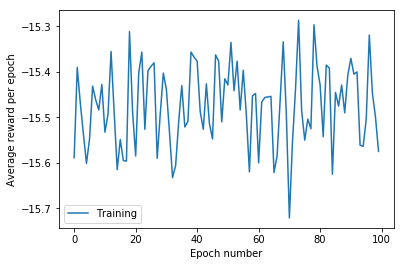

In [13]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.plot(list(episode_reward_train.keys()), list(episode_reward_train.values()), label='Training')
# plt.plot(list(episode_reward_test.keys()), list(episode_reward_test.values()), label='Testing')
# plt.plot(list(episode_reward_rand.keys()), list(episode_reward_rand.values()), label='Testing rand')

plt.xlabel('Epoch number')
plt.ylabel('Average reward per epoch')
plt.legend()

last_n = 10
train_avg = np.mean(np.array(list(episode_reward_train.values())[-last_n:]))
# test_avg = np.mean(np.array(list(episode_reward_test.values())[-last_n:]))
# rand_avg = np.mean(np.array(list(episode_reward_rand.values())[-last_n:]))

print("Average reward for last", last_n, "epochs in training:", round(train_avg, 3))
# print("Average reward for last", last_n, "epochs in testing:", round(test_avg, 3))
# print("Average reward for last", last_n, "epochs in testing random policy:", round(rand_avg, 3))

Average length for last 10 epochs in training: 16.464


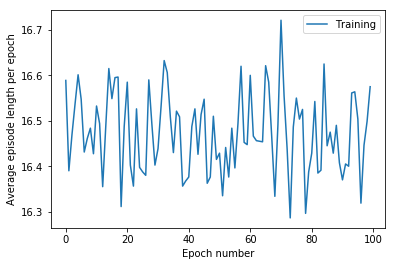

In [14]:
plt.plot(list(episode_length_train.keys()), list(episode_length_train.values()), label='Training')
# plt.plot(list(episode_length_test.keys()), list(episode_length_test.values()), label='Testing')
# plt.plot(list(episode_length_rand.keys()), list(episode_length_rand.values()), label='Testing rand')

plt.xlabel('Epoch number')
plt.ylabel('Average episode length per epoch')
plt.legend()

train_avg = np.mean(np.array(list(episode_length_train.values())[-last_n:]))
# test_avg = np.mean(np.array(list(episode_length_test.values())[-last_n:]))
# rand_avg = np.mean(np.array(list(episode_length_rand.values())[-last_n:]))

print("Average length for last", last_n, "epochs in training:", round(train_avg, 3))
# print("Average length for last", last_n, "epochs in testing:", round(test_avg, 3))
# print("Average length for last", last_n, "epochs in testing random policy:", round(rand_avg, 3))

Load the saved model and see how it performs

In [16]:
from keras.models import load_model

numVars = 20

loaded_estimator = Estimator(numVars)
loaded_estimator.model = load_model('cnn_10_files_adam.h5')

env = Env(input_file='../Tests/SATLIB_20/uf20-0106.cnf', numVars=numVars)
state = env.reset()
env.step(1)
state = env.get_state()

loaded_estimator.predict(PROCESS_STATE(state))
# p = make_epsilon_greedy_policy(loaded_estimator, actions)
# p(PROCESS_STATE(state), epsilon=0.1)

array([-5.307166 , -5.3361015, -5.5659876, -5.648487 ], dtype=float32)

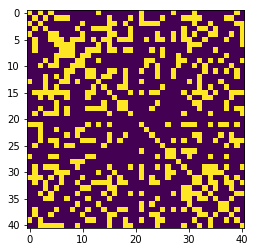

In [44]:
imshow(state)

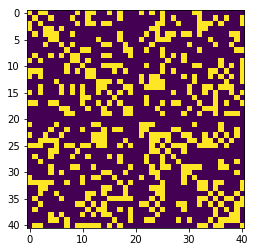

In [40]:
imshow(state)

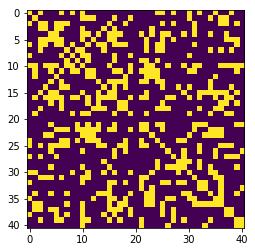

In [42]:
from matplotlib.pyplot import imshow
imshow(state)

**PROBLEM IS THAT THE CNN NETWORK PREDICTS THE SAME POSITIVE DISTRIBUTION OVER ALL THE ACTIONS FOR ALL INPUTS. DOESN'T GIVE EXPECTED REWARD IN NEGATIVE EITHER**

In [ ]:
array([0.05668544, 0.6025393 , 0.2770689 , 0.06370638], dtype=float32)

3D conv:
array([-5.30704  , -5.3359804, -5.5663304, -5.648637 ], dtype=float32)